In [61]:
from IPython.display import Image
#Image(filename='ANTI-INFECTIVES-RGB_200pc.png')

Populating the interactive namespace from numpy and matplotlib


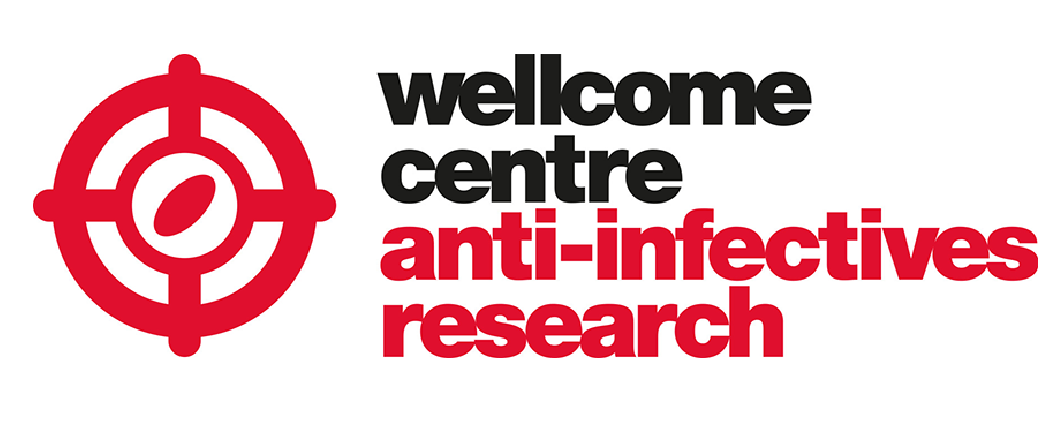

In [62]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots(figsize=(18, 10))
img=mpimg.imread('ANTI-INFECTIVES-RGB_200pc.png')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()


# Analysis of Senescent Proteins in Human

Michele Tinti and Michael A.J. Ferguson

Wellcome Centre for Anti-Infectives Research
School of Life Sciences, University of Dundee


## Aims
We are analysing normal versus oncogene-induced senescent cells to identify putative drug targets. We are particularly interested in transmembrane protein and protein with signal peptides that are likely to be transported on the cell plasma membrane. <b>Note for the boss:</b> What about extracellular proteins such as collagen?

In [63]:
import sys
print(sys.version)

3.7.1 | packaged by conda-forge | (default, Mar 13 2019, 13:32:59) [MSC v.1900 64 bit (AMD64)]


In [64]:
#iteresting ref for tmt/ibaq data normalization
#https://pwilmart.github.io/IRS_normalization/understanding_IRS.html

#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import os
from tqdm import tqdm
from tqdm import tqdm_notebook
import missingno as msno
from scipy import stats
import gc
import warnings
warnings.filterwarnings("ignore")

In [65]:
#define helping function
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from adjustText import adjust_text

def make_scatter_matrix(in_df):
    sns.set(font_scale = 1)
    #sns.set(style="white")
    def corrfunc(x, y, **kws):
        r, _ = stats.pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("r = {:.3f}".format(r),
                    xy=(.1, .9), xycoords=ax.transAxes)
    
    g = sns.PairGrid(in_df, palette=["red"]) 
    g.map_upper(plt.scatter, s=10)
    g.map_diag(sns.distplot, kde=False) 
    g.map_lower(sns.kdeplot, cmap="Blues_d") 
    g.map_lower(corrfunc)
    plt.show()


def make_pca(in_df, palette, top=500):
    cols = in_df.columns
    pca = PCA(n_components=2)
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    pca.fit(in_df)
    temp_df = pd.DataFrame()
    temp_df['pc_1']=pca.components_[0]
    temp_df['pc_2']=pca.components_[1]
    temp_df.index = cols
    print(pca.explained_variance_ratio_)
    temp_df['color']=palette
    fig,ax=plt.subplots(figsize=(12,6))
    temp_df.plot(kind='scatter',x='pc_1',y='pc_2',s=30, c=temp_df['color'], ax=ax)
    #print(temp_df.index.values)
       
    texts = [plt.text(temp_df.iloc[i]['pc_1'], 
                       temp_df.iloc[i]['pc_2'],
                       cols[i])
                       for i in range(temp_df.shape[0])]
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    ax.set_title('PCA',size=14)
    ax.set_xlabel('PC1_{:.3f}'.format(pca.explained_variance_ratio_[0]),size=12)
    ax.set_ylabel('PC2_{:.3f}'.format(pca.explained_variance_ratio_[1]),size=12)
    
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)
    plt.show()
    
def make_mds(in_df, palette, top=500):
    cols = in_df.columns
    pca = MDS(n_components=2,metric=True)
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    temp_df = pd.DataFrame(pca.fit_transform(in_df.T),
                                 index=cols,columns =['pc_1','pc_2'] )
    
    temp_df['color']=palette
    fig,ax=plt.subplots(figsize=(12,6))
    temp_df.plot(kind='scatter',x='pc_1',y='pc_2',s=50, c=temp_df['color'], ax=ax)
    #print(temp_df.index.values)
       
    texts = [plt.text(temp_df.iloc[i]['pc_1'], 
                       temp_df.iloc[i]['pc_2'],
                       cols[i])
                       for i in range(temp_df.shape[0])]
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    ax.set_title('MDS',size=14)
    ax.set_xlabel('DIM_1',size=12)
    ax.set_ylabel('DIM_2',size=12)
    
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)

    plt.show()


## Labeling efficiency
We can get an indirect estimate of the labelling efficiency by taking the ratio of the number of peptides with zero TMT intensity vs the total peptides identified. We can estimate the ratio for all the TMT channels.

In [66]:
TXT_PATH = 'D:\\michele\\old_age\\raw_4x\\combined\\txt\\'

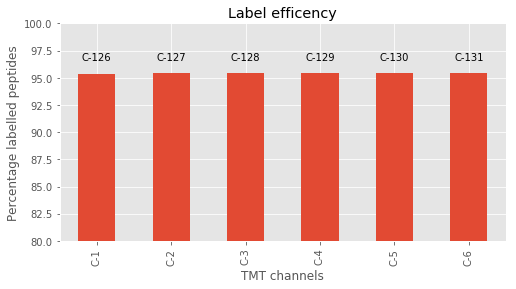

In [67]:
path=TXT_PATH+'evidence.txt'
evi = pd.read_table(path)
temp = evi[['Reporter intensity corrected {}'.format(n) for n in range(1,7)]]
fig,ax=plt.subplots(figsize=(8,4))
(temp.replace(0,np.nan).notnull().sum(axis=0)/temp.shape[0]*100).plot(kind='bar',ax=ax)
ax.set_xticklabels(['C-'+str(n) for n in [1,2,3,4,5,6]])
ax.set_xlabel('TMT channels')
ax.set_ylabel('Percentage labelled peptides')
ax.set_title('Label efficency')
ax.set_ylim(80,100)
rects = ax.patches
labels = ["C-%d" % i for i in [126,127,128,129,130,131]]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom')

plt.show()

In [68]:
del evi
gc.collect()

35991

## Dataset analysis

In [69]:
#load the datasetD:\michele\old_age\raw\combined\txt
df = pd.read_table(os.path.join(TXT_PATH, 'proteinGroups.txt'))
df.head()
#print(df.columns)
df = df[df['Only identified by site']!='+']
df = df[df['Potential contaminant']!='+']
df = df[df['Reverse']!='+']
#print(list(df.columns))
cols = ['Reporter intensity corrected {}'.format(n) for n in range(1,7)]
data=df[cols]
data.columns = ['S1','S2','S3', 'C1','C2','C3']

### Missing Data Analysis

(8109, 6)


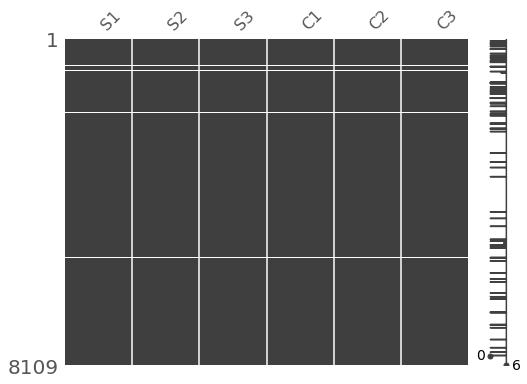

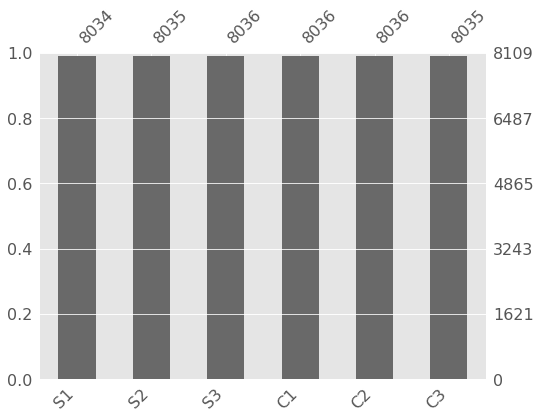

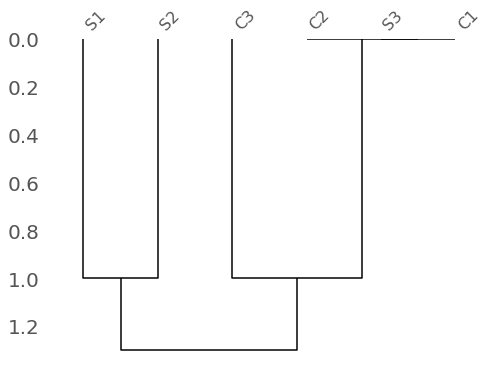

(8109, 6)


In [70]:
print(data.shape)
data=data.replace(0, np.nan)
msno.matrix(data, figsize=(8, 6))
#plt.title('Missing Data')
plt.show()

msno.bar(data, figsize=(8, 6))
plt.show()

msno.dendrogram(data, figsize=(8, 6))
plt.show()

data=data.replace(np.nan,0)
data = data.dropna(how='all')
print(data.shape)

This picture show that we identified an 6614 protein groups. For the moment we do not use any filter for the number of unique peptides

In [71]:
#how many protein group with two unique peptides?
df[df['Unique peptides']>=2].shape

(6964, 98)

In [72]:
#df['Protein IDs']

In [73]:
#df['myco']=[1 if 'MYCO' in n.split('|')[1] else 0 for n in df['Protein IDs']]
#df[df['myco']==1]['Score'].plot(kind='hist',histtype='step')
#df[df['myco']==0]['Score'].plot(kind='hist',histtype='step')

### Average Intensity

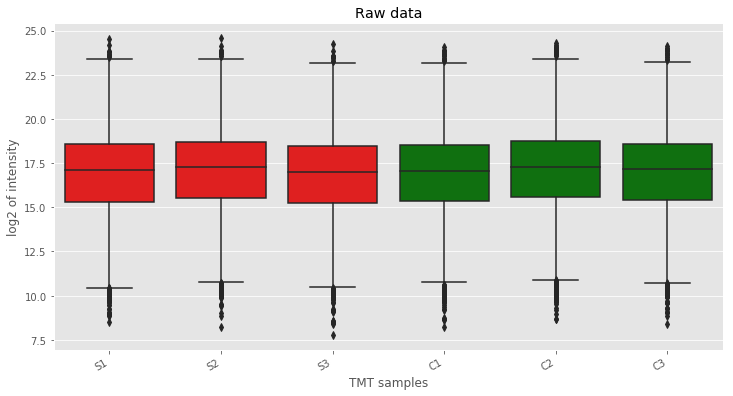

In [74]:
my_pal = ["r"]*3+["g"]*3
fig,ax=plt.subplots(figsize=(12,6))
g = sns.boxplot(data=np.log2(data),ax=ax,palette=my_pal)
g.set_xticklabels(data.columns, rotation=30, ha='right')
plt.title('Raw data')
plt.xlabel('TMT samples')
plt.ylabel('log2 of intensity')
plt.show()

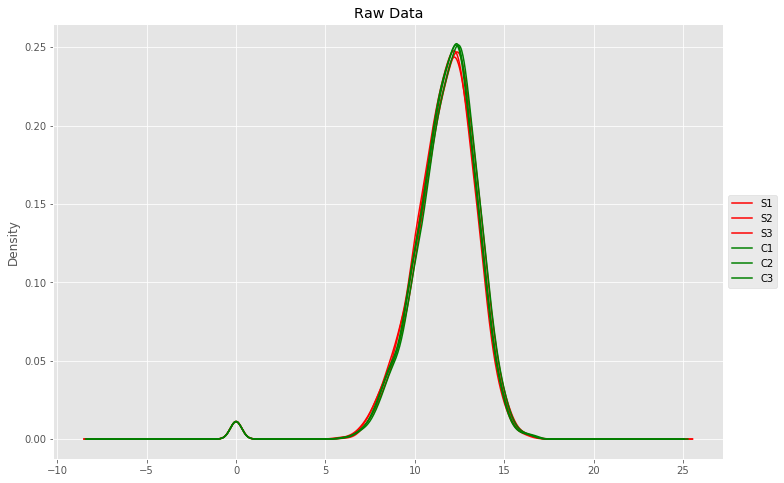

In [75]:
fig,ax=plt.subplots(figsize=(12,8))
np.log1p(data).plot(kind='kde',ax=ax,color=my_pal)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Raw Data')
plt.show()

Tee pictures above show a very good distribution of the TMT channel intensity for bot senescent (S1,S2,S3) and control (C1 C2 C3) cells.

### PCA analysis


[0.95576099 0.04059654]


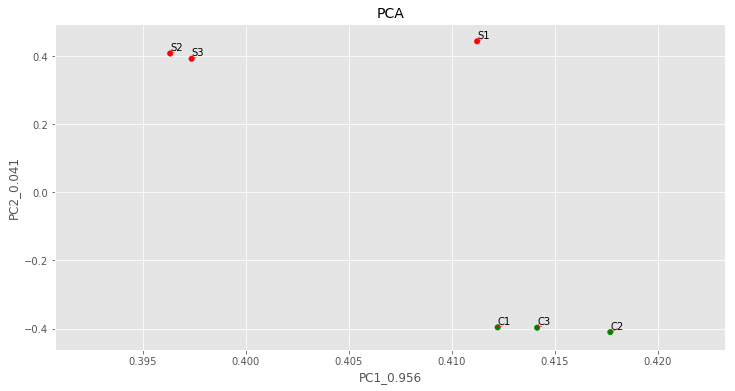

In [76]:
make_pca(np.log2(data), my_pal)

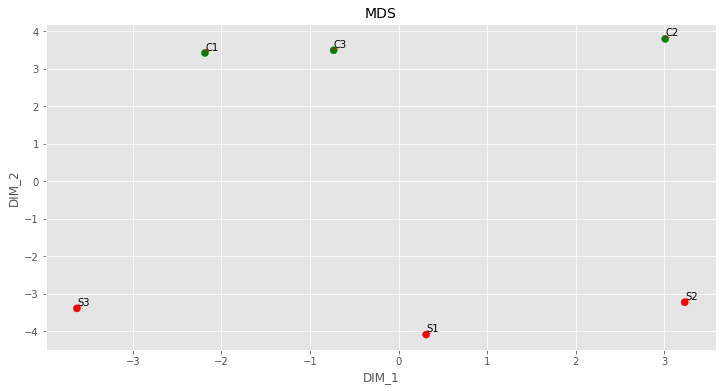

In [77]:
make_mds(np.log2(data), my_pal)

With two dimensinality reduction tecniques (PCA and MDS) we observe a good separation of senescent (S1,S2,S3) and control (C1 C2 C3) cells.

### Reproducibility analysis

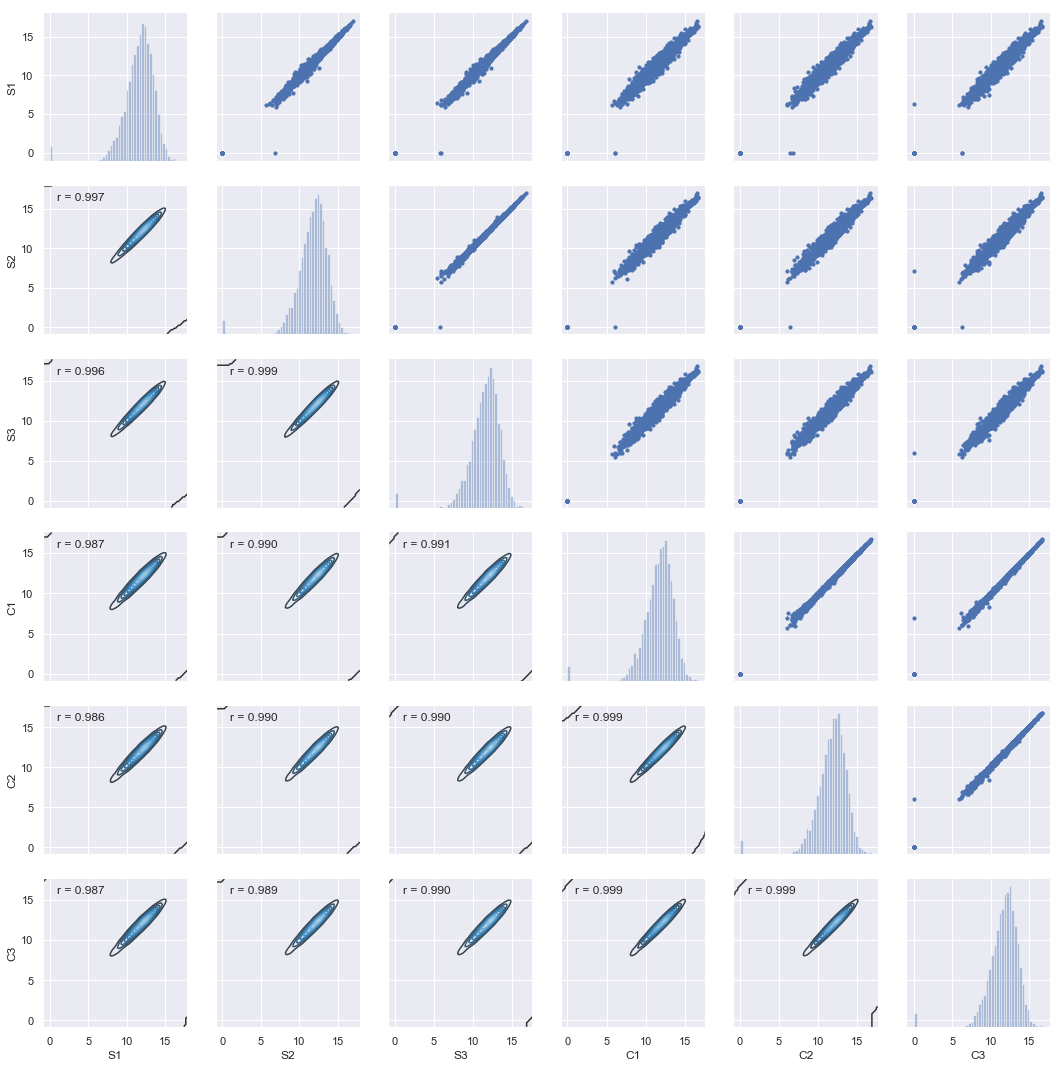

In [78]:
make_scatter_matrix(np.log1p(data))

The figure above show a very good intraclass correlation  between the senescent samples (S1,S2,S3) and the control samples (C1 C2 C3). As expected, the correletion decrese between samples of different classes.

### Data Normalization
We do a correction for sample loading artefact. We do not expect the signal to change much.

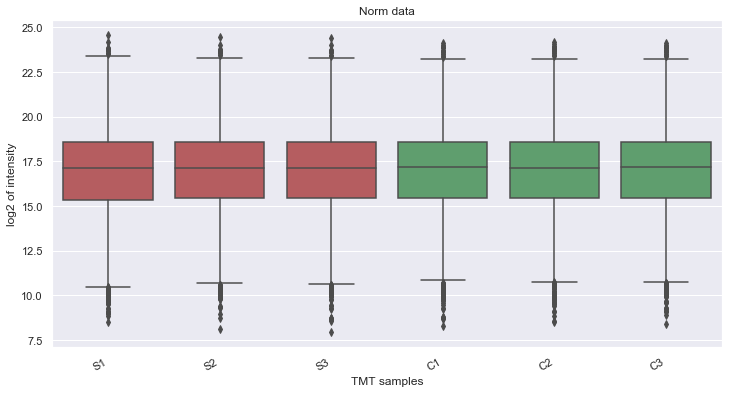

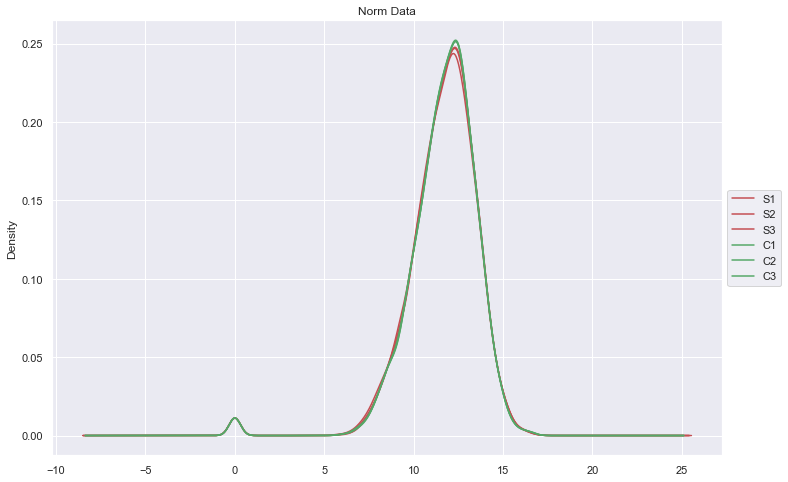

In [79]:
#normalization
#we create normalization factors based on the average sum intensity of each channel
col_sum = data.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
data_norm = data.multiply(norm_facs, axis=1)


fig,ax=plt.subplots(figsize=(12,6))
g = sns.boxplot(data=np.log2(data_norm),ax=ax,palette=my_pal)
g.set_xticklabels(data.columns, rotation=30, ha='right')
plt.title('Norm data')
plt.xlabel('TMT samples')
plt.ylabel('log2 of intensity')
plt.show()
fig,ax=plt.subplots(figsize=(12,8))
np.log1p(data_norm).plot(kind='kde',ax=ax,color=my_pal)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm Data')
plt.show()

In [80]:
df['Gene names']=['_'.join(n.split(';')[0].split(' ')[0].split('|')[1:]) for n in df['Fasta headers']]

In [81]:
data_norm['genes'] = data_norm.index.map(df['Gene names'])
data_norm['genes']=[str(n).split(';')[0] for n in data_norm['genes']]
data_norm['genes']=[str(n[0])+'_'+str(n[1]) for n in zip(data_norm.index.values,data_norm['genes'])]
data_norm.to_csv(TXT_PATH+'norm_data_maxquant16660_4x.csv',sep='\t',index=False)

In [82]:
#df.head()

In [83]:
data_norm.head(6)

,S1,S2,S3,C1,C2,C3,genes
0,25751.243059,25071.083640,28196.923632,34615.438962,38589.445554,37528.279675,0_Q13286_CLN3_HUMAN
1,25763.366521,28340.336600,27118.598047,34972.440712,34253.359985,36684.401834,1_Q9H1N7_S35B3_HUMAN
2,197076.973736,173196.105696,181766.869317,153236.135983,163598.946044,148103.596648,2_A0A024R1R8_A0A024R1R8_HUMAN
3,279122.501173,280384.879605,280286.105851,259333.253845,257591.119582,255460.238066,3_A0A024R216_A0A024R216_HUMAN
4,29113.483120,32763.115747,32217.361268,27417.311951,26109.539203,28392.340794,4_A0A024R368_A0A024R368_HUMAN
5,43252.470393,48402.590349,51683.326136,173145.848991,167627.053029,164535.942140,5_A0A024R3B9_A0A024R3B9_HUMAN


### Testing for differences.
We use limma package in R to identify protein with a differential expression between normal and senescent cells.

In [23]:
#%load_ext rpy2.ipython

In [24]:
#%R require(ggplot2); require(tidyr)
#%R X=c(1,4,5,7); sd(X); mean(X)

In [1]:
options(warn=-1)
library("tidyverse")
library("psych")
library("gridExtra")
library("scales")
library("limma") 
library("edgeR") 
limma_data <- read_tsv('D:\\michele\\old_age\\raw_4x\\combined\\txt\\norm_data_maxquant16660_4x.csv')
accession <- limma_data$'genes'
limma_data = within(limma_data, rm('genes'))


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'scales'

The following objects are masked from 'package:psych':

    alpha, rescale

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor

Parsed with column specification:
cols(
  S1 = col_double(),
  S2 = col_double(),
  S3 = col_double(),
  C1 = col_double(),
  C2 = col_double(),
  C3 = col

In [3]:
head(accession)
head(limma_data)

[1] "0_Q13286_CLN3_HUMAN"           "1_Q9H1N7_S35B3_HUMAN"         
[3] "2_A0A024R1R8_A0A024R1R8_HUMAN" "3_A0A024R216_A0A024R216_HUMAN"
[5] "4_A0A024R368_A0A024R368_HUMAN" "5_A0A024R3B9_A0A024R3B9_HUMAN"

S1,S2,S3,C1,C2,C3
25751.24,25071.08,28196.92,34615.44,38589.45,37528.28
25763.37,28340.34,27118.60,34972.44,34253.36,36684.40
197076.97,173196.11,181766.87,153236.14,163598.95,148103.60
279122.50,280384.88,280286.11,259333.25,257591.12,255460.24
29113.48,32763.12,32217.36,27417.31,26109.54,28392.34
43252.47,48402.59,51683.33,173145.85,167627.05,164535.94


In [4]:

row.names(limma_data) <- accession # add accessions as row names
# set up the design matrix
group <- as.factor(c(rep("senescent", 3), rep("control", 3)))
group <- factor(group, levels(group)[c(2, 1)]) # set the factor order
design <- model.matrix(~ 0 + group)
colnames(design) <- c("senescent", "control")
design
# make the contrast
contrast <- makeContrasts(senescent-control, levels = design)
contrast


senescent,control
1,0
1,0
1,0
0,1
0,1
0,1


,senescent - control
senescent,1
control,-1


In [5]:
group

[1] senescent senescent senescent control   control   control  
Levels: senescent control

In [6]:
S <- 1:3
C <- 4:6
# do the linear model fitting on log2 values
limma_log_data <- log2(limma_data[c(S, C)])
fit <- lmFit(limma_log_data, design)

# get the fit for the contrast of interest
fit2 <- contrasts.fit(fit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
fit2 <- eBayes(fit2, trend = TRUE)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(fit2, coef = 1, sort.by = "none", number = Inf)

# let's see how many up and down candidates, and the top tags
summary(decideTests(fit2, p.value = 0.10))
topTable(fit2)


       senescent - control
Down                  2644
NotSig                2628
Up                    2764

,logFC,AveExpr,t,P.Value,adj.P.Val,B
2321,1.545399,19.87378,68.59659,7.550844e-11,3.993108e-07,15.62724
2991,1.747603,20.52225,63.12992,1.321222e-10,3.993108e-07,15.17903
4570,-2.159736,18.57751,-57.09946,2.598021e-10,3.993108e-07,14.60853
947,-1.061894,20.04454,-54.83554,3.411507e-10,3.993108e-07,14.37040
2781,-1.121388,20.82385,-54.25024,3.667105e-10,3.993108e-07,14.30648
4791,-1.086122,21.09815,-54.17170,3.703050e-10,3.993108e-07,14.29782
3440,1.240850,22.38306,53.91938,3.821290e-10,3.993108e-07,14.26990
1404,1.153183,19.54034,53.23785,4.162950e-10,3.993108e-07,14.19353
4256,-1.414477,18.33132,-52.26530,4.713052e-10,3.993108e-07,14.08208
2997,1.601327,19.19400,51.65699,5.099486e-10,3.993108e-07,14.01086


In [7]:
limma_data$ave_med <- rowMeans(limma_data[S])
limma_data$ave_exo  <- rowMeans(limma_data[C])
limma_data$logFC <- log2(limma_data$ave_exo / limma_data$ave_med)
limma_data$FC <- ifelse(limma_data$ave_exo > limma_data$ave_med, 
                          (limma_data$ave_exo / limma_data$ave_med), 
                          (-1 * limma_data$ave_med / limma_data$ave_exo))
limma_data$Acc <- accession
head(limma_data)

S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc
25751.24,25071.08,28196.92,34615.44,38589.45,37528.28,26339.75,36911.05,0.4868113,1.401344,0_Q13286_CLN3_HUMAN
25763.37,28340.34,27118.60,34972.44,34253.36,36684.40,27074.10,35303.40,0.3828938,1.303955,1_Q9H1N7_S35B3_HUMAN
197076.97,173196.11,181766.87,153236.14,163598.95,148103.60,184013.32,154979.56,-0.2477322,-1.187339,2_A0A024R1R8_A0A024R1R8_HUMAN
279122.50,280384.88,280286.11,259333.25,257591.12,255460.24,279931.16,257461.54,-0.1207152,-1.087274,3_A0A024R216_A0A024R216_HUMAN
29113.48,32763.12,32217.36,27417.31,26109.54,28392.34,31364.65,27306.40,-0.1999006,-1.148619,4_A0A024R368_A0A024R368_HUMAN
43252.47,48402.59,51683.33,173145.85,167627.05,164535.94,47779.46,168436.28,1.8177404,3.525286,5_A0A024R3B9_A0A024R3B9_HUMAN


In [8]:
# statisticl test results
limma_data$PValue <- tt_limma$P.Value
limma_data$FDR <- tt_limma$adj.P.Val
head(limma_data)
# add a DE candidate status column
limma_data$candidate <- cut(limma_data$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))

S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR
25751.24,25071.08,28196.92,34615.44,38589.45,37528.28,26339.75,36911.05,0.4868113,1.401344,0_Q13286_CLN3_HUMAN,2.108723e-04,8.032289e-04
25763.37,28340.34,27118.60,34972.44,34253.36,36684.40,27074.10,35303.40,0.3828938,1.303955,1_Q9H1N7_S35B3_HUMAN,2.918194e-04,1.047838e-03
197076.97,173196.11,181766.87,153236.14,163598.95,148103.60,184013.32,154979.56,-0.2477322,-1.187339,2_A0A024R1R8_A0A024R1R8_HUMAN,4.447301e-03,9.864343e-03
279122.50,280384.88,280286.11,259333.25,257591.12,255460.24,279931.16,257461.54,-0.1207152,-1.087274,3_A0A024R216_A0A024R216_HUMAN,1.624261e-03,4.246115e-03
29113.48,32763.12,32217.36,27417.31,26109.54,28392.34,31364.65,27306.40,-0.1999006,-1.148619,4_A0A024R368_A0A024R368_HUMAN,1.874497e-02,3.342407e-02
43252.47,48402.59,51683.33,173145.85,167627.05,164535.94,47779.46,168436.28,1.8177404,3.525286,5_A0A024R3B9_A0A024R3B9_HUMAN,3.964658e-08,1.978881e-06


In [9]:
# add a DE candidate status column
limma_data$candidate <- cut(limma_data$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))


In [10]:
# count candidates
print("Candidate Counts:")
summary(limma_data$candidate)

[1] "Candidate Counts:"


high  med  low   no NA's 
3636 1177  595 2628   73

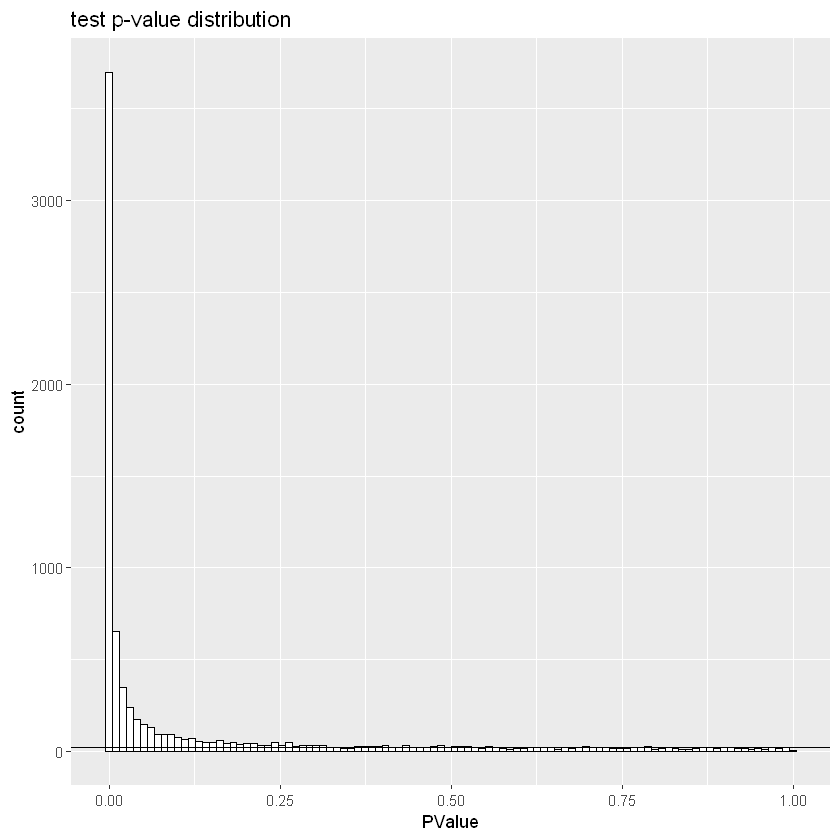

In [11]:
pvalue_plot <- function(results, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # title - plot title
    ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100])) +
        ggtitle(str_c(title, " p-value distribution"))
}

pvalue_plot(limma_data, "test")

The figure above show the expected distribution of p-value, our test is safe

In [12]:
head(limma_data)

S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate
25751.24,25071.08,28196.92,34615.44,38589.45,37528.28,26339.75,36911.05,0.4868113,1.401344,0_Q13286_CLN3_HUMAN,2.108723e-04,8.032289e-04,high
25763.37,28340.34,27118.60,34972.44,34253.36,36684.40,27074.10,35303.40,0.3828938,1.303955,1_Q9H1N7_S35B3_HUMAN,2.918194e-04,1.047838e-03,high
197076.97,173196.11,181766.87,153236.14,163598.95,148103.60,184013.32,154979.56,-0.2477322,-1.187339,2_A0A024R1R8_A0A024R1R8_HUMAN,4.447301e-03,9.864343e-03,high
279122.50,280384.88,280286.11,259333.25,257591.12,255460.24,279931.16,257461.54,-0.1207152,-1.087274,3_A0A024R216_A0A024R216_HUMAN,1.624261e-03,4.246115e-03,high
29113.48,32763.12,32217.36,27417.31,26109.54,28392.34,31364.65,27306.40,-0.1999006,-1.148619,4_A0A024R368_A0A024R368_HUMAN,1.874497e-02,3.342407e-02,med
43252.47,48402.59,51683.33,173145.85,167627.05,164535.94,47779.46,168436.28,1.8177404,3.525286,5_A0A024R3B9_A0A024R3B9_HUMAN,3.964658e-08,1.978881e-06,high


In [14]:
write.table(limma_data,'D:\\michele\\old_age\\raw_4x\\combined\\txt\\limma_data_maxquant16660_4x.txt')
#data_norm = pd.read_csv('norm_data.csv',sep='\t')
#print(data_norm.shape)
#data_norm.head()
#del data_norm['gene_names']

## Restart python  Kernel

In [29]:
print(data_norm.shape)
data_norm.head()

(8109, 7)


,S1,S2,S3,C1,C2,C3,genes
0,25751.243059,25071.083640,28196.923632,34615.438962,38589.445554,37528.279675,0_Q13286_CLN3_HUMAN
1,25763.366521,28340.336600,27118.598047,34972.440712,34253.359985,36684.401834,1_Q9H1N7_S35B3_HUMAN
2,197076.973736,173196.105696,181766.869317,153236.135983,163598.946044,148103.596648,2_A0A024R1R8_A0A024R1R8_HUMAN
3,279122.501173,280384.879605,280286.105851,259333.253845,257591.119582,255460.238066,3_A0A024R216_A0A024R216_HUMAN
4,29113.483120,32763.115747,32217.361268,27417.311951,26109.539203,28392.340794,4_A0A024R368_A0A024R368_HUMAN


In [84]:
#we load back the R analysis
r_analysis = pd.read_table(TXT_PATH+'limma_data_maxquant16660_4x.txt',sep=' ')
print(r_analysis.shape)
r_analysis = r_analysis.reset_index(drop=True)
r_analysis.head()

(8109, 14)


,S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate
0,25751.243059,25071.083640,28196.923632,34615.438962,38589.445554,37528.279675,26339.750110,36911.054730,0.486811,1.401344,0_Q13286_CLN3_HUMAN,0.000211,0.000803,high
1,25763.366521,28340.336600,27118.598047,34972.440712,34253.359985,36684.401834,27074.100389,35303.400844,0.382894,1.303955,1_Q9H1N7_S35B3_HUMAN,0.000292,0.001048,high
2,197076.973736,173196.105696,181766.869317,153236.135983,163598.946044,148103.596648,184013.316250,154979.559558,-0.247732,-1.187339,2_A0A024R1R8_A0A024R1R8_HUMAN,0.004447,0.009864,high
3,279122.501173,280384.879605,280286.105851,259333.253845,257591.119582,255460.238066,279931.162210,257461.537165,-0.120715,-1.087274,3_A0A024R216_A0A024R216_HUMAN,0.001624,0.004246,high
4,29113.483120,32763.115747,32217.361268,27417.311951,26109.539203,28392.340794,31364.653378,27306.397316,-0.199901,-1.148619,4_A0A024R368_A0A024R368_HUMAN,0.018745,0.033424,med


In [113]:
data_def = data_norm.merge(r_analysis.iloc[:,6:],left_on='genes',right_on='Acc' )
data_def.shape

(8109, 15)

In [114]:
#top 50 proteins
data_def.sort_values('FDR').head(10)

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate
7509,1.371467e+06,1.359712e+06,1.385665e+06,2.655333e+06,2.705876e+06,2.688571e+06,7771_Q9NZN4_EHD2_HUMAN,1.372281e+06,2.683260e+06,0.967411,1.955328,7771_Q9NZN4_EHD2_HUMAN,6.459731e-10,3.993108e-07,high
2996,1.087778e+06,1.033251e+06,1.014456e+06,3.470205e+05,3.435090e+05,3.424080e+05,3190_P03956_MMP1_HUMAN,1.045162e+06,3.443125e+05,-1.601936,-3.035503,3190_P03956_MMP1_HUMAN,5.099486e-10,3.993108e-07,high
43,6.801868e+05,6.814814e+05,6.881535e+05,1.338757e+06,1.337494e+06,1.336140e+06,45_A0A087WTA8_A0A087WTA8_HUMAN,6.832739e+05,1.337464e+06,0.968964,1.957434,45_A0A087WTA8_A0A087WTA8_HUMAN,5.970895e-10,3.993108e-07,high
3439,8.302753e+06,8.577795e+06,8.348776e+06,3.481929e+06,3.586551e+06,3.606819e+06,3638_P24821_TENA_HUMAN,8.409775e+06,3.558433e+06,-1.240825,-2.363337,3638_P24821_TENA_HUMAN,3.821290e-10,3.993108e-07,high
2990,2.733335e+06,2.821310e+06,2.725325e+06,8.469074e+05,8.040589e+05,8.150706e+05,3184_P03372_ESR1_HUMAN,2.759990e+06,8.220123e+05,-1.747431,-3.357602,3184_P03372_ESR1_HUMAN,1.321222e-10,3.993108e-07,high
946,7.534934e+05,7.443773e+05,7.475792e+05,1.572920e+06,1.552357e+06,1.562489e+06,988_B4DDF4_B4DDF4_HUMAN,7.484833e+05,1.562589e+06,1.061896,2.087673,988_B4DDF4_B4DDF4_HUMAN,3.411507e-10,3.993108e-07,high
4790,1.513412e+06,1.554753e+06,1.554090e+06,3.258328e+06,3.290042e+06,3.264107e+06,5004_Q15746_MYLK_HUMAN,1.540752e+06,3.270826e+06,1.086020,2.122876,5004_Q15746_MYLK_HUMAN,3.703050e-10,3.993108e-07,high
2320,1.665865e+06,1.608993e+06,1.649804e+06,5.579050e+05,5.663735e+05,5.627674e+05,2504_O00534_VMA5A_HUMAN,1.641554e+06,5.623486e+05,-1.545525,-2.919104,2504_O00534_VMA5A_HUMAN,7.550844e-11,3.993108e-07,high
4255,1.981782e+05,2.063344e+05,2.016054e+05,5.313200e+05,5.448692e+05,5.393634e+05,4461_P98082_DAB2_HUMAN,2.020393e+05,5.385175e+05,1.414357,2.665409,4461_P98082_DAB2_HUMAN,4.713052e-10,3.993108e-07,high
1403,1.119299e+06,1.144889e+06,1.147334e+06,5.132798e+05,5.074692e+05,5.131061e+05,1549_E9PB90_E9PB90_HUMAN,1.137174e+06,5.112850e+05,-1.153253,-2.224148,1549_E9PB90_E9PB90_HUMAN,4.162950e-10,3.993108e-07,high


The top 20 protein by FDR are all under represented in senescent cell

## Visualize differential expression

In [115]:
data_def['log10p']=-np.log10(data_def['PValue'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


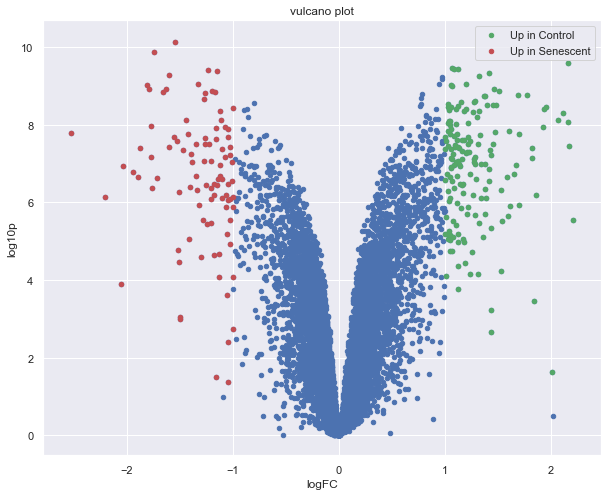

In [116]:
fig,ax=plt.subplots(figsize=(10,8))

data_def.plot(kind='scatter',x='logFC',y='log10p',ax=ax)

data_def[(data_def['PValue']<0.05) & (data_def['logFC']>1)].plot(
    kind='scatter',x='logFC',y='log10p',ax=ax, c='g', label='Up in Control')

data_def[(data_def['PValue']<0.05) & (data_def['logFC']<-1)].plot(
    kind='scatter',x='logFC',y='log10p',ax=ax, c='r', label='Up in Senescent')
plt.legend()
plt.title('vulcano plot')
plt.show()

## Interactive Vulcano Plot


In [117]:
up_control = data_def[(data_def['PValue']<0.05) & (data_def['logFC']>1)]
up_senescent = data_def[(data_def['PValue']<0.05) & (data_def['logFC']<-1)]
the_rest = data_def.iloc[~data_def.index.isin( list(up_control.index.values) + list(up_senescent.index.values) ) ]
#the_rest = the_rest.iloc[~up_senescent.index.values]

In [118]:
print(up_senescent.shape)
up_senescent.sort_values('logFC').head(10)

(97, 16)


,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate,log10p
97,3.268990e+04,3.272504e+04,3.429659e+04,6351.884992,5581.547348,5293.056804,100_A0A087WW59_A0A087WW59_HUMAN,3.323718e+04,5742.163048,-2.533132,-5.788268,100_A0A087WW59_A0A087WW59_HUMAN,1.581156e-08,1.296548e-06,high,7.801025
4254,1.374902e+04,1.513794e+04,1.552632e+04,2665.260998,3328.516925,3613.193505,4460_P98066_TSG6_HUMAN,1.480442e+04,3202.323809,-2.208837,-4.623026,4460_P98066_TSG6_HUMAN,7.296299e-07,1.221522e-05,high,6.136897
6256,6.682856e+04,3.484169e+04,3.587424e+04,9970.066046,10316.830963,12670.309744,6501_Q93083_MT1L_HUMAN,4.584817e+04,10985.735584,-2.061233,-4.173427,6501_Q93083_MT1L_HUMAN,1.231731e-04,5.259402e-04,high,3.909484
3614,1.442894e+06,1.867189e+06,1.736317e+06,412886.255286,400426.348228,413813.813768,3815_P35354_PGH2_HUMAN,1.682134e+06,409042.139094,-2.039971,-4.112372,3815_P35354_PGH2_HUMAN,1.145980e-07,3.805411e-06,high,6.940823
3727,2.495413e+05,3.234982e+05,2.950079e+05,74790.810511,75044.716936,75849.844995,3929_P42830_CXCL5_HUMAN,2.893491e+05,75228.457481,-1.943461,-3.846272,3929_P42830_CXCL5_HUMAN,1.648590e-07,4.697898e-06,high,6.782887
1102,1.276095e+05,1.030000e+05,1.020157e+05,29480.106089,29137.844746,30862.251837,1153_C9J4T6_C9J4T6_HUMAN,1.108751e+05,29826.734224,-1.894257,-3.717305,1153_C9J4T6_C9J4T6_HUMAN,2.212759e-07,5.644993e-06,high,6.655066
119,3.075015e+05,3.630450e+05,3.638255e+05,94929.722868,91174.304975,95784.182343,123_A0A087WX92_A0A087WX92_HUMAN,3.447907e+05,93962.736729,-1.875560,-3.669440,123_A0A087WX92_A0A087WX92_HUMAN,3.871856e-08,1.978881e-06,high,7.412081
819,2.053411e+05,2.020250e+05,2.088765e+05,57871.251217,56679.800469,60788.548035,856_A6NFF2_NP1L6_HUMAN,2.054142e+05,58446.533240,-1.813347,-3.514566,856_A6NFF2_NP1L6_HUMAN,9.520568e-10,4.199664e-07,high,9.021337
3939,4.243111e+05,4.033069e+05,3.871424e+05,118708.363131,115090.061247,117029.869429,4142_P52823_STC1_HUMAN,4.049201e+05,116942.764603,-1.791835,-3.462550,4142_P52823_STC1_HUMAN,1.230570e-09,4.457813e-07,high,8.909894
7009,7.680011e+05,8.802464e+05,8.736569e+05,247978.908230,242156.063891,244987.653347,7266_Q9H2J7_S6A15_HUMAN,8.406348e+05,245040.875156,-1.778457,-3.430590,7266_Q9H2J7_S6A15_HUMAN,1.064891e-08,1.056477e-06,high,7.972695


In [119]:
#up_control.head()

In [120]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
#interactive plot 'logFC',y='log10p'


trace_1 = go.Scatter(
    x=the_rest.logFC,
    y=the_rest.log10p,
    mode='markers',
    name='MA Plot',
    #text = [a + ' ' +b for a,b in zip(temp.index.values, temp.Gene_desc)],
    #hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'blue'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

trace_2 = go.Scatter(
    x=up_control.logFC,
    y=up_control.log10p,
    mode='markers',
    name='MA Plot',
    text = up_control.genes,
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'green'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

trace_3 = go.Scatter(
    x=up_senescent.logFC,
    y=up_senescent.log10p,
    mode='markers',
    name='MA Plot',
    text = up_control.genes,
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'red'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

'''

annot_1 = go.Scatter(
    x=[temp.signal_perc.loc['Tb927.3.2610']],
    y=[temp.signal_logfc.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)
'''

layout = dict(title='Vulcano',
             width=1000,
             height=800)


fig = go.Figure(data=[trace_1,trace_2,trace_3], 
                layout=layout)
iplot(fig, filename='test')

In [121]:
#attach the old index so we can grab other columns from the MaxQuont ProteinGroup file
data_def['index']=[int(n.split('_')[0]) for n in data_def['genes']]
data_def.head()
data_def.set_index('index',inplace=True,drop=True)

In [122]:
#df.head()
#write proteins for go enrichemnt analysis
#data_def[data_def['logFC']<-1].sort_values('PValue').to_csv('up_senescent.csv')

### Visualize some top candidates


In [123]:
value_cols = ['Reporter intensity corrected {}'.format(n) for n in range(1,7)]

def plot_data(ax='', 
              ids=[], 
              dataframe=pd.DataFrame(), 
              title='',
              typeOfPlot = 'swarm'):
    temp = dataframe[dataframe['id'].isin(ids)][value_cols]
    temp.columns=['S1','S2','S3','C1','C2','C3']
    temp=temp.replace(0,np.nan)
    temp = temp.dropna(thresh=1,axis=1)
    if typeOfPlot == 'swarm':
        sns.swarmplot(data=temp,ax=ax)#, color)
    if typeOfPlot == 'box':
        sns.boxplot(data=temp,ax=ax, showfliers=False)#, color)
    
    ax.set_xlabel('Sample')
    ax.set_ylabel('TMT intensity')
    ax.set_title(title)
    
def plot_prot(ax = '', 
              prot_id = 2742, 
              dataframe=pd.DataFrame()):
    temp = dataframe.loc[prot_id][value_cols]
    #print(temp.head())
    temp.plot(kind='bar', ax=ax, colors=my_pal)
    ax.set_xlabel('Sample')
    ax.set_ylabel('TMT intensity')
    ax.set_xticklabels(['S1','S2','S3','C1','C2','C3'],rotation=-360)
    ax.set_title(df.loc[prot_id]['Gene names'])
    
def make_plot(prot_id= 5064, typeOfPlot='swarm'):
    gridsize = (2, 2)
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (1, 1), colspan=1, rowspan=1)
    ax3 = plt.subplot2grid(gridsize, (0, 1), colspan=1, rowspan=1)
    plot_prot(ax1, prot_id = prot_id, dataframe=df)
    ids = df.loc[prot_id]['Peptide IDs'].split(';')
    ids=[int(n) for n in ids]
    plot_data(ax2, ids = ids, dataframe=peptides,
              title ='Peptides', typeOfPlot=typeOfPlot)
    ids = df.loc[prot_id]['Evidence IDs'].split(';')
    ids=[int(n) for n in ids]
    plot_data(ax3, ids = ids, dataframe=evi,
              title ='Evidences', typeOfPlot=typeOfPlot)
    plt.tight_layout()
    plt.show()
    
#data_def[data_def['logFC']<-1].sort_values('PValue').head()

In [124]:
peptides = pd.read_table(os.path.join('raw_4x', 'combined', 'txt', 'peptides.txt'))
evi =  pd.read_table(os.path.join('raw_4x', 'combined', 'txt', 'evidence.txt'))
#peptides['Protein group IDs'].head(),evi['Protein group IDs'].head()

In [125]:
peptides['id']=peptides['id'].astype(int)
evi['id'] = evi['id'].astype(int)

In [126]:
up_senescent.sort_values('FC').head(10)

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate,log10p
97,3.268990e+04,3.272504e+04,3.429659e+04,6351.884992,5581.547348,5293.056804,100_A0A087WW59_A0A087WW59_HUMAN,3.323718e+04,5742.163048,-2.533132,-5.788268,100_A0A087WW59_A0A087WW59_HUMAN,1.581156e-08,1.296548e-06,high,7.801025
4254,1.374902e+04,1.513794e+04,1.552632e+04,2665.260998,3328.516925,3613.193505,4460_P98066_TSG6_HUMAN,1.480442e+04,3202.323809,-2.208837,-4.623026,4460_P98066_TSG6_HUMAN,7.296299e-07,1.221522e-05,high,6.136897
6256,6.682856e+04,3.484169e+04,3.587424e+04,9970.066046,10316.830963,12670.309744,6501_Q93083_MT1L_HUMAN,4.584817e+04,10985.735584,-2.061233,-4.173427,6501_Q93083_MT1L_HUMAN,1.231731e-04,5.259402e-04,high,3.909484
3614,1.442894e+06,1.867189e+06,1.736317e+06,412886.255286,400426.348228,413813.813768,3815_P35354_PGH2_HUMAN,1.682134e+06,409042.139094,-2.039971,-4.112372,3815_P35354_PGH2_HUMAN,1.145980e-07,3.805411e-06,high,6.940823
3727,2.495413e+05,3.234982e+05,2.950079e+05,74790.810511,75044.716936,75849.844995,3929_P42830_CXCL5_HUMAN,2.893491e+05,75228.457481,-1.943461,-3.846272,3929_P42830_CXCL5_HUMAN,1.648590e-07,4.697898e-06,high,6.782887
1102,1.276095e+05,1.030000e+05,1.020157e+05,29480.106089,29137.844746,30862.251837,1153_C9J4T6_C9J4T6_HUMAN,1.108751e+05,29826.734224,-1.894257,-3.717305,1153_C9J4T6_C9J4T6_HUMAN,2.212759e-07,5.644993e-06,high,6.655066
119,3.075015e+05,3.630450e+05,3.638255e+05,94929.722868,91174.304975,95784.182343,123_A0A087WX92_A0A087WX92_HUMAN,3.447907e+05,93962.736729,-1.875560,-3.669440,123_A0A087WX92_A0A087WX92_HUMAN,3.871856e-08,1.978881e-06,high,7.412081
819,2.053411e+05,2.020250e+05,2.088765e+05,57871.251217,56679.800469,60788.548035,856_A6NFF2_NP1L6_HUMAN,2.054142e+05,58446.533240,-1.813347,-3.514566,856_A6NFF2_NP1L6_HUMAN,9.520568e-10,4.199664e-07,high,9.021337
3939,4.243111e+05,4.033069e+05,3.871424e+05,118708.363131,115090.061247,117029.869429,4142_P52823_STC1_HUMAN,4.049201e+05,116942.764603,-1.791835,-3.462550,4142_P52823_STC1_HUMAN,1.230570e-09,4.457813e-07,high,8.909894
7009,7.680011e+05,8.802464e+05,8.736569e+05,247978.908230,242156.063891,244987.653347,7266_Q9H2J7_S6A15_HUMAN,8.406348e+05,245040.875156,-1.778457,-3.430590,7266_Q9H2J7_S6A15_HUMAN,1.064891e-08,1.056477e-06,high,7.972695


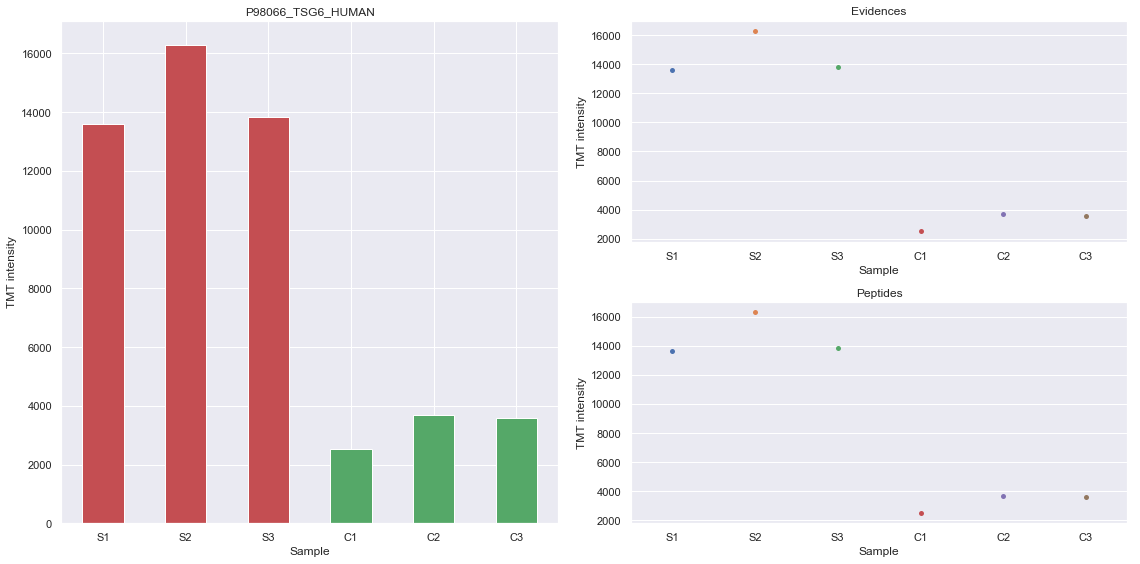

In [127]:
make_plot(prot_id= 4460, typeOfPlot='swarm')

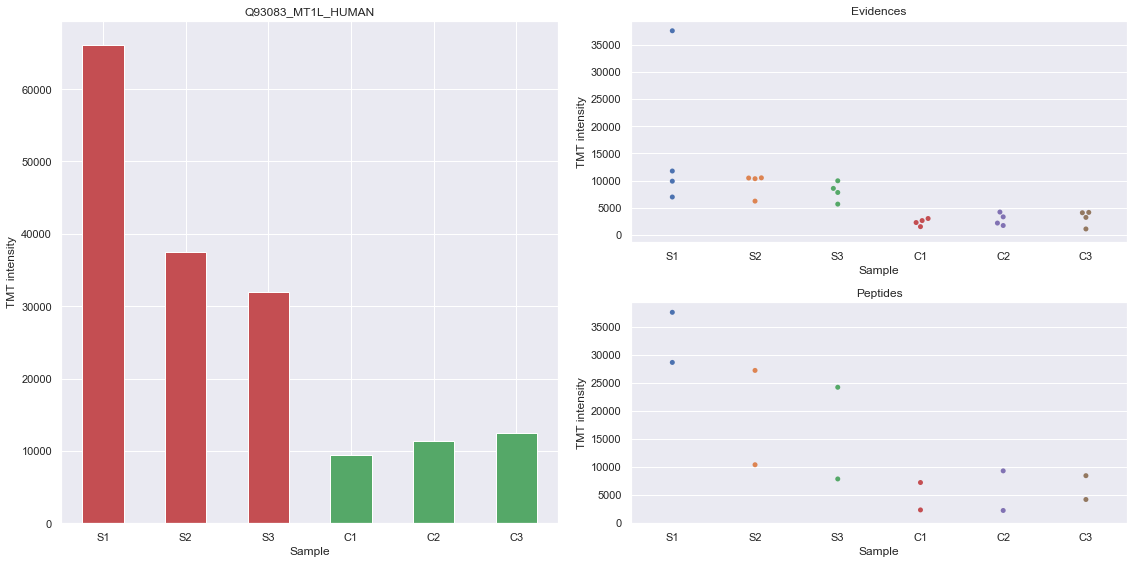

In [128]:
make_plot(prot_id= 6501)

## Go term analysis
Ae select protein with a log2 fold change greather than 1 between Senescent and control
for go term analysis we will be using david online and visualize the outputs.

Also, if possible, we will select the uniprot-sprot ID between the ids of a protein group as the uniprot-sprot are likely to be better annotated.

In [129]:
np.log2(1/1.3)

-0.37851162325372995

In [130]:
unknows = ['PAQR5_HUMAN','ITPI2_HUMAN','WLS_HUMAN','QTRT2_HUMAN']

def select_id(in_col):
    res = []
    for n in in_col:
        #print(n)
        temp = []
        item_list = n.split(';')
        for acc in item_list:
            #print (acc)
            if acc.count('|') >=2:
                temp_id = acc.split(' ')[0].split('|')[1]
                temp_type = acc.split(' ')[0].split('|')[0]
                #print (temp_type)
                if temp_type == 'sp' and temp_id:
                    temp.append(temp_id)
                    
                    break
        if len(temp) == 0:
            temp_id = item_list[0].split(' ')[0].split('|')[1]
            res.append(temp_id)
        else:
            res.append(temp[0])
    return res
             

df.columns
temp = df[['Protein IDs', 'Majority protein IDs', 'Peptide counts (all)',
       'Peptide counts (razor+unique)', 'Peptide counts (unique)',
        'Gene names', 'Fasta headers', 'Number of proteins',
       'Peptides', 'Razor + unique peptides', 'Unique peptides', 'Sequence coverage [%]',
       'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]',
       'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths',
        'Q-value','Score']]
temp.head()
data_def=data_def.join(temp,how='left')
data_def['david_input']=select_id(data_def['Fasta headers'])

In [131]:
sprot_features = pd.read_table(TXT_PATH+'uniprot//uniprot-yourlist.tab')
data_def = data_def.merge(sprot_features, left_on='david_input', right_on=sprot_features.columns[-1])
data_def.head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,...,Subcellular location [CC],Topological domain,Transit peptide,Propeptide,Glycosylation,Disulfide bond,Cross-link,Region,Gene ontology (cellular component),yourlist:M20190603216DA2B77BFBD2E6699CA9B6D1C41EB21B8AA5H
0,25751.243059,25071.083640,28196.923632,34615.438962,38589.445554,37528.279675,0_Q13286_CLN3_HUMAN,26339.750110,36911.054730,0.486811,...,SUBCELLULAR LOCATION: Lysosome membrane {ECO:0...,TOPO_DOM 1 37 Cytoplasmic. {ECO:0000255}.; TOP...,NaN,PROPEP 436 438 Removed in mature form. {ECO:00...,CARBOHYD 71 71 N-linked (GlcNAc...) asparagine...,NaN,NaN,NaN,autophagosome [GO:0005776]; caveola [GO:000590...,Q13286
1,25763.366521,28340.336600,27118.598047,34972.440712,34253.359985,36684.401834,1_Q9H1N7_S35B3_HUMAN,27074.100389,35303.400844,0.382894,...,SUBCELLULAR LOCATION: Golgi apparatus membrane...,NaN,NaN,NaN,CARBOHYD 12 12 N-linked (GlcNAc...) asparagine...,NaN,NaN,NaN,Golgi membrane [GO:0000139]; integral componen...,Q9H1N7
2,197076.973736,173196.105696,181766.869317,153236.135983,163598.946044,148103.596648,2_A0A024R1R8_A0A024R1R8_HUMAN,184013.316250,154979.559558,-0.247732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q9Y2S6
3,279122.501173,280384.879605,280286.105851,259333.253845,257591.119582,255460.238066,3_A0A024R216_A0A024R216_HUMAN,279931.162210,257461.537165,-0.120715,...,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cytosol [GO:0005829]; extracellular region [GO...,Q9Y3E1
4,29113.483120,32763.115747,32217.361268,27417.311951,26109.539203,28392.340794,4_A0A024R368_A0A024R368_HUMAN,31364.653378,27306.397316,-0.199901,...,SUBCELLULAR LOCATION: Nucleus membrane {ECO:00...,NaN,NaN,PROPEP 842 844 Removed in mature form. {ECO:00...,NaN,NaN,NaN,NaN,cytoplasm [GO:0005737]; nuclear membrane [GO:0...,Q7Z3G6


In [136]:
data_def.to_csv(TXT_PATH+'data_def.csv')

## Analysis of UP senescent

In [137]:
selection_senescent = data_def[data_def['logFC']<-0.38].sort_values('FDR')
selection_senescent.to_csv(TXT_PATH+'up_senescent_maxquant16660_4x.csv')
selection_senescent.head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,...,Subcellular location [CC],Topological domain,Transit peptide,Propeptide,Glycosylation,Disulfide bond,Cross-link,Region,Gene ontology (cellular component),yourlist:M20190603216DA2B77BFBD2E6699CA9B6D1C41EB21B8AA5H
2990,2.733335e+06,2.821310e+06,2.725325e+06,8.469074e+05,8.040589e+05,8.150706e+05,3184_P03372_ESR1_HUMAN,2.759990e+06,8.220123e+05,-1.747431,...,SUBCELLULAR LOCATION: Isoform 1: Nucleus {ECO:...,NaN,NaN,NaN,CARBOHYD 10 10 O-linked (GlcNAc) serine. {ECO:...,NaN,NaN,REGION 1 184 Modulating (transactivation AF-1)...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,P03372
2320,1.665865e+06,1.608993e+06,1.649804e+06,5.579050e+05,5.663735e+05,5.627674e+05,2504_O00534_VMA5A_HUMAN,1.641554e+06,5.623486e+05,-1.545525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nucleoplasm [GO:0005654]; nucleus [GO:0005634],O00534
3439,8.302753e+06,8.577795e+06,8.348776e+06,3.481929e+06,3.586551e+06,3.606819e+06,3638_P24821_TENA_HUMAN,8.409775e+06,3.558433e+06,-1.240825,...,"SUBCELLULAR LOCATION: Secreted, extracellular ...",NaN,NaN,NaN,CARBOHYD 38 38 N-linked (GlcNAc...) asparagine...,DISULFID 190 200 {ECO:0000250}.; DISULFID 194 ...,NaN,NaN,basement membrane [GO:0005604]; collagen-conta...,P24821
1403,1.119299e+06,1.144889e+06,1.147334e+06,5.132798e+05,5.074692e+05,5.131061e+05,1549_E9PB90_E9PB90_HUMAN,1.137174e+06,5.112850e+05,-1.153253,...,SUBCELLULAR LOCATION: Mitochondrion outer memb...,NaN,NaN,NaN,NaN,NaN,NaN,REGION 1 12 Hydrophobic.; REGION 13 475 Regula...,cytosol [GO:0005829]; membrane [GO:0016020]; m...,P52789
2996,1.087778e+06,1.033251e+06,1.014456e+06,3.470205e+05,3.435090e+05,3.424080e+05,3190_P03956_MMP1_HUMAN,1.045162e+06,3.443125e+05,-1.601936,...,"SUBCELLULAR LOCATION: Secreted, extracellular ...",NaN,NaN,PROPEP 20 99 Activation peptide. {ECO:0000269|...,CARBOHYD 120 120 N-linked (GlcNAc...) asparagi...,DISULFID 278 466 {ECO:0000250}.,NaN,REGION 98 276 Metalloprotease.,extracellular matrix [GO:0031012]; extracellul...,P03956


### David Chart
This is an enrichment analysis for all the annotation keywords stored in the david database.
It is the most similar approch to the classical GO-term enrichment analysis. With david database, we have the benefit to test not only the go annotation but also several other controlled vocabulary annotation such as Panther, OMIM disease, uniprot keywords and so on

In [138]:
selection_senescent.head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,...,Subcellular location [CC],Topological domain,Transit peptide,Propeptide,Glycosylation,Disulfide bond,Cross-link,Region,Gene ontology (cellular component),yourlist:M20190603216DA2B77BFBD2E6699CA9B6D1C41EB21B8AA5H
2990,2.733335e+06,2.821310e+06,2.725325e+06,8.469074e+05,8.040589e+05,8.150706e+05,3184_P03372_ESR1_HUMAN,2.759990e+06,8.220123e+05,-1.747431,...,SUBCELLULAR LOCATION: Isoform 1: Nucleus {ECO:...,NaN,NaN,NaN,CARBOHYD 10 10 O-linked (GlcNAc) serine. {ECO:...,NaN,NaN,REGION 1 184 Modulating (transactivation AF-1)...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,P03372
2320,1.665865e+06,1.608993e+06,1.649804e+06,5.579050e+05,5.663735e+05,5.627674e+05,2504_O00534_VMA5A_HUMAN,1.641554e+06,5.623486e+05,-1.545525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nucleoplasm [GO:0005654]; nucleus [GO:0005634],O00534
3439,8.302753e+06,8.577795e+06,8.348776e+06,3.481929e+06,3.586551e+06,3.606819e+06,3638_P24821_TENA_HUMAN,8.409775e+06,3.558433e+06,-1.240825,...,"SUBCELLULAR LOCATION: Secreted, extracellular ...",NaN,NaN,NaN,CARBOHYD 38 38 N-linked (GlcNAc...) asparagine...,DISULFID 190 200 {ECO:0000250}.; DISULFID 194 ...,NaN,NaN,basement membrane [GO:0005604]; collagen-conta...,P24821
1403,1.119299e+06,1.144889e+06,1.147334e+06,5.132798e+05,5.074692e+05,5.131061e+05,1549_E9PB90_E9PB90_HUMAN,1.137174e+06,5.112850e+05,-1.153253,...,SUBCELLULAR LOCATION: Mitochondrion outer memb...,NaN,NaN,NaN,NaN,NaN,NaN,REGION 1 12 Hydrophobic.; REGION 13 475 Regula...,cytosol [GO:0005829]; membrane [GO:0016020]; m...,P52789
2996,1.087778e+06,1.033251e+06,1.014456e+06,3.470205e+05,3.435090e+05,3.424080e+05,3190_P03956_MMP1_HUMAN,1.045162e+06,3.443125e+05,-1.601936,...,"SUBCELLULAR LOCATION: Secreted, extracellular ...",NaN,NaN,PROPEP 20 99 Activation peptide. {ECO:0000269|...,CARBOHYD 120 120 N-linked (GlcNAc...) asparagi...,DISULFID 278 466 {ECO:0000250}.,NaN,REGION 98 276 Metalloprotease.,extracellular matrix [GO:0031012]; extracellul...,P03956


In [139]:
david_chart = pd.read_table(TXT_PATH+'david\\'+'chart_CCC911C949E91559550575186.txt')
david_chart.columns
genes = david_chart.Genes
del david_chart['Genes']
print(david_chart.shape)
david_chart[['Category','Term','Count','PValue']].head(30)

(616, 12)


,Category,Term,Count,PValue
0,UP_KEYWORDS,Phosphoprotein,384,1.227580e-14
1,GOTERM_BP_DIRECT,GO:0030198~extracellular matrix organization,34,7.304809e-13
2,UP_KEYWORDS,Electron transport,20,4.612244e-09
3,UP_KEYWORDS,Mitochondrion,78,4.833420e-09
4,GOTERM_BP_DIRECT,GO:0030574~collagen catabolic process,16,1.410148e-08
5,UP_KEYWORDS,Respiratory chain,15,2.245043e-08
6,GOTERM_CC_DIRECT,GO:0005739~mitochondrion,91,2.616095e-08
7,UP_KEYWORDS,Extracellular matrix,29,8.482000e-08
8,GOTERM_BP_DIRECT,GO:0032981~mitochondrial respiratory chain com...,15,8.828118e-08
9,GOTERM_CC_DIRECT,GO:0005615~extracellular space,90,9.142211e-08


In [140]:
selection.head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,...,Unique peptides,Sequence coverage [%],Unique + razor sequence coverage [%],Unique sequence coverage [%],Mol. weight [kDa],Sequence length,Sequence lengths,Q-value,Score,david_input
index,,,,,,,,,,,,,,,,,,,,,
3184,2.733335e+06,2.821310e+06,2.725325e+06,8.469074e+05,8.040589e+05,8.150706e+05,3184_P03372_ESR1_HUMAN,2.759990e+06,8.220123e+05,-1.747431,...,11,23.2,23.2,23.2,66.215,595,595;334;310;107,0.0,133.410,P03372
2504,1.665865e+06,1.608993e+06,1.649804e+06,5.579050e+05,5.663735e+05,5.627674e+05,2504_O00534_VMA5A_HUMAN,1.641554e+06,5.623486e+05,-1.545525,...,30,48.1,48.1,48.1,86.488,786,786;431,0.0,323.310,O00534
3638,8.302753e+06,8.577795e+06,8.348776e+06,3.481929e+06,3.586551e+06,3.606819e+06,3638_P24821_TENA_HUMAN,8.409775e+06,3.558433e+06,-1.240825,...,4,53.4,53.4,2.8,240.850,2201,2201;1928,0.0,323.310,P24821
1549,1.119299e+06,1.144889e+06,1.147334e+06,5.132798e+05,5.074692e+05,5.131061e+05,1549_E9PB90_E9PB90_HUMAN,1.137174e+06,5.112850e+05,-1.153253,...,24,35.8,31.5,31.5,98.972,889,889;917;923,0.0,156.030,P52789
3190,1.087778e+06,1.033251e+06,1.014456e+06,3.470205e+05,3.435090e+05,3.424080e+05,3190_P03956_MMP1_HUMAN,1.045162e+06,3.443125e+05,-1.601936,...,17,45.0,45.0,45.0,54.006,469,469,0.0,67.409,P03956


### David Cluster
Another peculiarity of david is to create cluster of similar keywords, that get togeter because they are releted to each other.

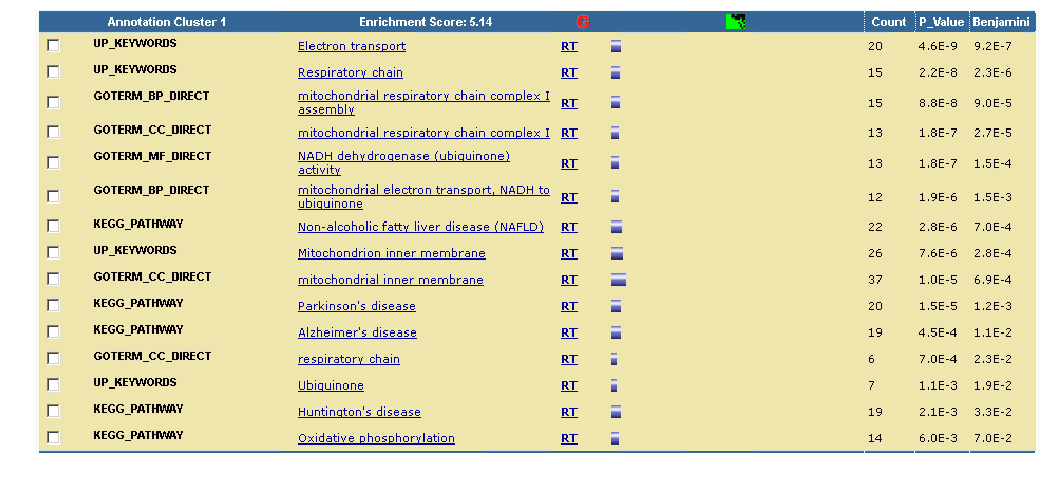

In [141]:
fig, ax = subplots(figsize=(18, 10))
img=mpimg.imread(TXT_PATH+'david\Capture_1.PNG')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()
#Image(filename='david/Capture.PNG') 

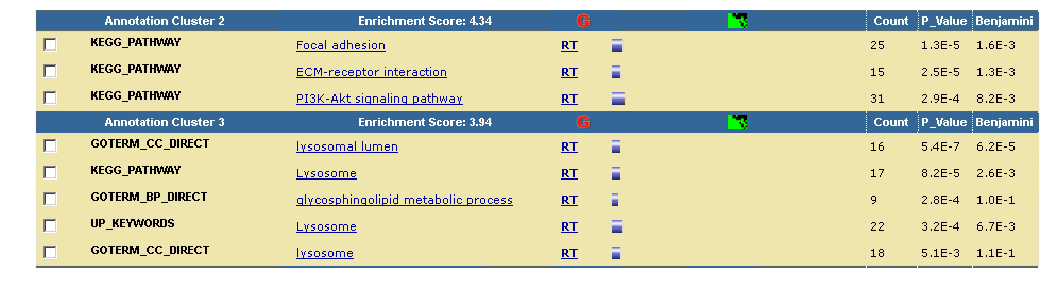

In [142]:
fig, ax = subplots(figsize=(18, 10))
img=mpimg.imread(TXT_PATH+'david\Capture_2.PNG')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()
#Image(filename='david/Capture.PNG') 

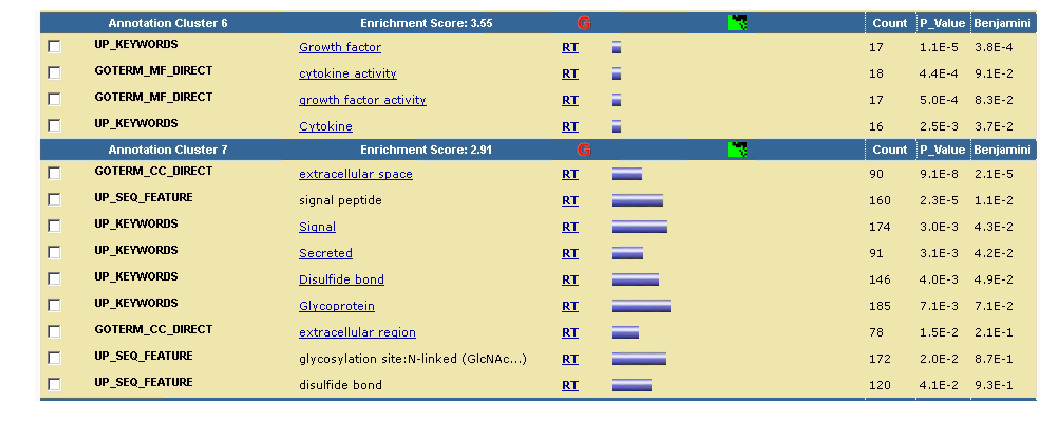

In [143]:
fig, ax = subplots(figsize=(18, 10))
img=mpimg.imread(TXT_PATH+'david\Capture_3.PNG')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()

## Vulcano Plot with only selected proteins
we add transmembrane regions and signal peptide 

In [144]:
selection_senescent.to_csv(TXT_PATH+'selection_senescent.csv')

In [146]:
selection_senescent = selection_senescent.replace(-np.inf,-4)
selection_senescent['log10p']=selection_senescent['log10p'].fillna(selection_senescent['log10p'].mean())
text_list = []
look_into = []
for n in selection_senescent.index.values:
    a=0
    text = selection_senescent['Protein names'].loc[n]
    text = text.split(' (')[0]
    text+='\n'
    #print (selection['Signal peptide'].loc[n])
    #if str(selection['Signal peptide'].loc[n]) != 'nan':
        #text+='has signal peptide\n'
        #a=1
    if str(selection_senescent['Transmembrane'].loc[n]) != 'nan':
        text+='has Transmembrane\n'
        a=1
    if a >0:
        look_into.append(n)
    
    text_list.append(text)   

In [147]:
selection_senescent.sort_values('FC').head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,...,Subcellular location [CC],Topological domain,Transit peptide,Propeptide,Glycosylation,Disulfide bond,Cross-link,Region,Gene ontology (cellular component),yourlist:M20190603216DA2B77BFBD2E6699CA9B6D1C41EB21B8AA5H
97,3.268990e+04,3.272504e+04,3.429659e+04,6351.884992,5581.547348,5293.056804,100_A0A087WW59_A0A087WW59_HUMAN,3.323718e+04,5742.163048,-2.533132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q7Z7L8
4254,1.374902e+04,1.513794e+04,1.552632e+04,2665.260998,3328.516925,3613.193505,4460_P98066_TSG6_HUMAN,1.480442e+04,3202.323809,-2.208837,...,NaN,NaN,NaN,NaN,CARBOHYD 118 118 N-linked (GlcNAc...) asparagi...,DISULFID 58 127; DISULFID 82 103; DISULFID 135...,NaN,NaN,extracellular region [GO:0005576]; extracellul...,P98066
6256,6.682856e+04,3.484169e+04,3.587424e+04,9970.066046,10316.830963,12670.309744,6501_Q93083_MT1L_HUMAN,4.584817e+04,10985.735584,-2.061233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REGION 1 29 Beta.; REGION 30 61 Alpha.,cytoplasm [GO:0005737]; nucleus [GO:0005634]; ...,Q93083
3614,1.442894e+06,1.867189e+06,1.736317e+06,412886.255286,400426.348228,413813.813768,3815_P35354_PGH2_HUMAN,1.682134e+06,409042.139094,-2.039971,...,SUBCELLULAR LOCATION: Microsome membrane; Peri...,NaN,NaN,NaN,CARBOHYD 53 53 N-linked (GlcNAc...) asparagine...,"DISULFID 21 32 {ECO:0000244|PDB:5F19, ECO:0000...",NaN,NaN,caveola [GO:0005901]; cytoplasm [GO:0005737]; ...,P35354
3727,2.495413e+05,3.234982e+05,2.950079e+05,74790.810511,75044.716936,75849.844995,3929_P42830_CXCL5_HUMAN,2.893491e+05,75228.457481,-1.943461,...,SUBCELLULAR LOCATION: Secreted.,NaN,NaN,NaN,NaN,"DISULFID 49 75 {ECO:0000244|PDB:2MGS, ECO:0000...",NaN,NaN,extracellular region [GO:0005576]; extracellul...,P42830


In [148]:
annotations =  selection_senescent[['Protein names']]
annotations['Protein names'] = [n.split('(')[0].strip() for n in annotations['Protein names']]
#['Protein names']
#interactive plot 'logFC',y='log10p'
trace_1 = go.Scatter(
    x=selection_senescent.loc[look_into].logFC,
    y=selection_senescent.loc[look_into].log10p,
    mode='markers',
    name='Transmembrane',
    text = annotations['Protein names'].loc[look_into],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'red'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

#interactive plot 'logFC',y='log10p'
trace_2 = go.Scatter(
    x=selection_senescent[~selection_senescent.index.isin(look_into)].logFC,
    y=selection_senescent[~selection_senescent.index.isin(look_into)].log10p,
    mode='markers',
    name='the rest',
    text = annotations[~annotations.index.isin(look_into)]['Protein names'],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'green'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

layout = dict(title='Vulcano, Transmembrane',
             width=1000,
             height=800)

fig = go.Figure(data=[trace_1,trace_2], 
                layout=layout)
iplot(fig, filename='test')

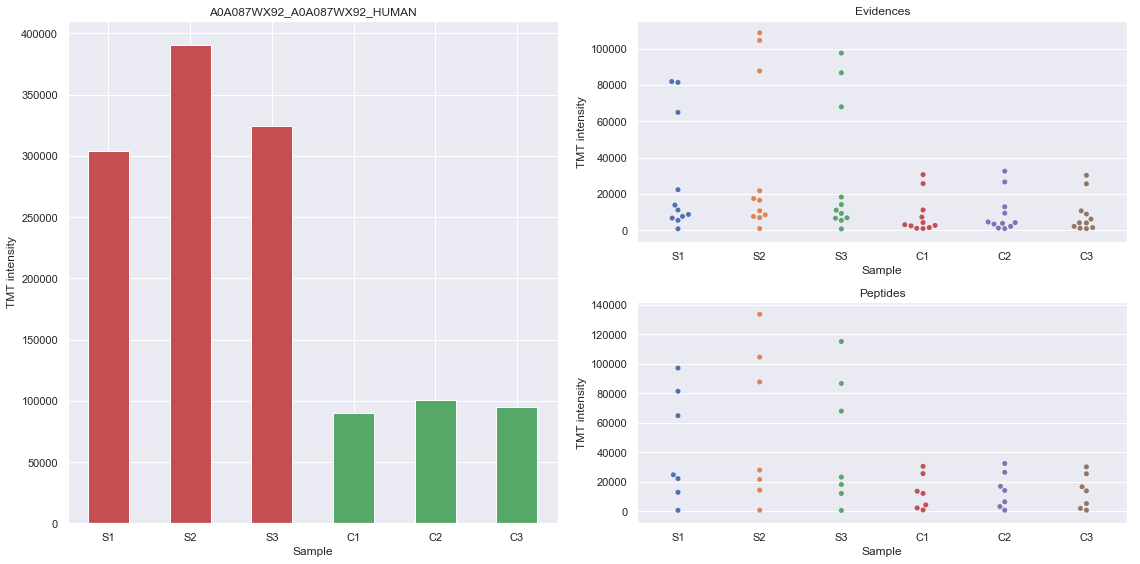

In [149]:
make_plot(prot_id= 123)

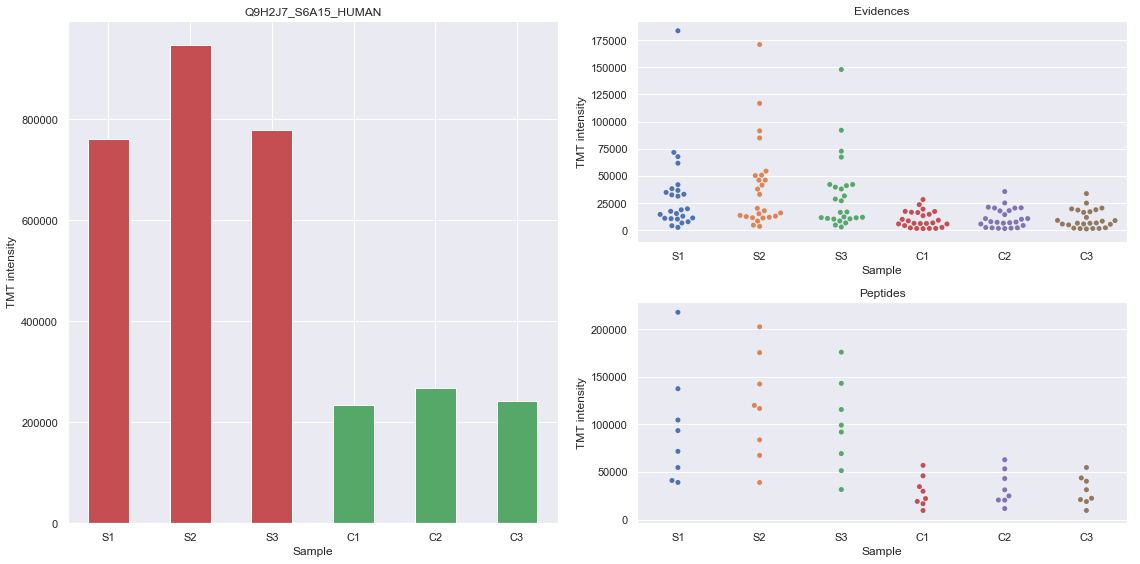

In [150]:
make_plot(prot_id= 7266)

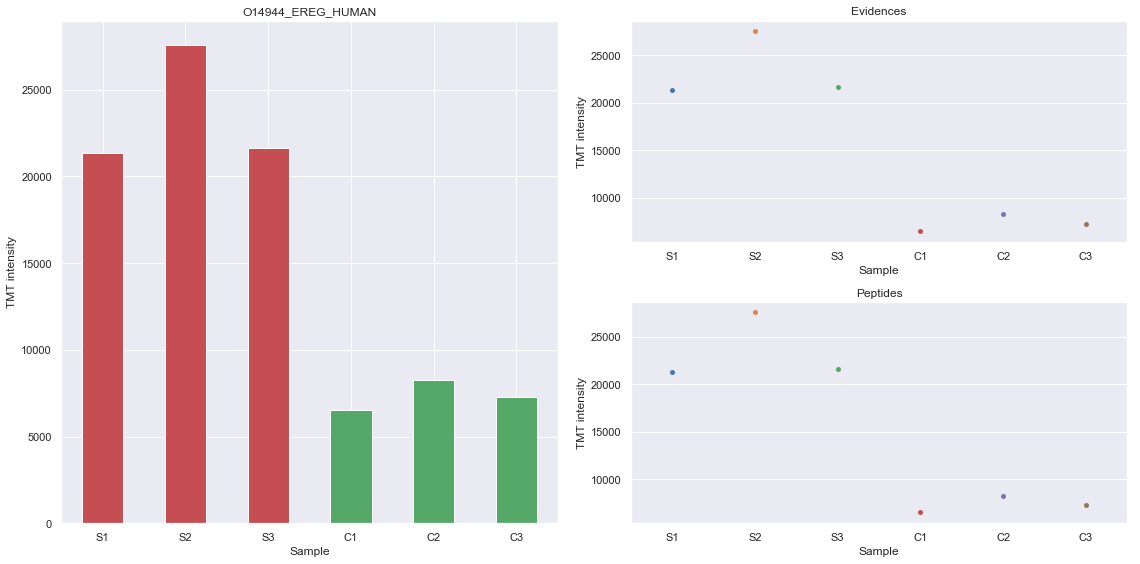

In [151]:
make_plot(prot_id= 2578)

In [58]:
data_def.shape

(8109, 16)